In [45]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import matplotlib.axes._axes as axes
sns.set()

In [46]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [47]:
# import the necessary packages
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
##
from tensorflow.keras.layers import Conv2D, Activation, Flatten, Dense, \
    Embedding, GlobalAveragePooling1D, Bidirectional, LSTM
from tensorflow.keras.optimizers import RMSprop, SGD
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, Sequential


In [48]:
# setting global variables
dbBase = r"refined_dataset"
all_sentences = []
all_labels = []

In [49]:
# reading the words from file and creating a dataset
types = ['Bearings', 'Bolts', 'Collets', 'Springs', 'Sprockets']
class_num = len(types)

for label, type in enumerate(types):

    with open(f"{dbBase}//{type}_100.txt", mode='r') as partFile:
        content = partFile.readlines()
        content = [c.replace("\n", "") for c in content]

        all_sentences.extend(content)
        all_labels.extend([label] * len(content))

all_sentences = np.array(all_sentences)
all_labels = np.array(all_labels)

# binarize the labels
le = LabelBinarizer()
all_labels = le.fit_transform(all_labels)

In [50]:
# do a trin test split
train_sentences, \
test_sentences, \
trainy, \
testy = train_test_split(all_sentences,
                         all_labels,
                         stratify=all_labels,
                         test_size=0.1,
                         random_state=42)

In [51]:
vocab_size = 374
embedding_dim = 50
max_length = 5
trunc_type = "post"
oov_tok = "<OOV>"

In [52]:
# tokenize the train set
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
train_sequences = tokenizer.texts_to_sequences(train_sentences)
padded_train_sequences = pad_sequences(train_sequences, maxlen=max_length,
                                       truncating=trunc_type)
# tokenise and pad the test set
test_sequences = tokenizer.texts_to_sequences(test_sentences)
padded_test_sequences = pad_sequences(test_sequences, maxlen=max_length)

# check out the word index
print(len(tokenizer.word_index.keys()))
print(tokenizer.word_index)

447
{'<OOV>': 1, 'holder': 2, 'workpiece': 3, 'elastic': 4, 'screw': 5, 'gear': 6, 'roller': 7, 'helical': 8, 'centering': 9, 'chain': 10, 'bearings': 11, 'wheel': 12, 'rear': 13, 'tool': 14, 'fastener': 15, 'energy': 16, 'element': 17, 'chuck': 18, 'gears': 19, 'self': 20, 'rod': 21, 'brake': 22, 'clamping': 23, 'machine': 24, 'threaded': 25, 'force': 26, 'pinion': 27, 'radial': 28, 'jaw': 29, 'shaft': 30, 'bolts': 31, 'coil': 32, 'sleeve': 33, 'tensioner': 34, 'shafts': 35, 'lever': 36, 'harmonic': 37, 'tapered': 38, 'member': 39, 'screws': 40, 'dowel': 41, 'tension': 42, 'hex': 43, 'piston': 44, 'concentric': 45, 'wrench': 46, 'torsion': 47, 'bevel': 48, 'holding': 49, 'gripper': 50, 'component': 51, 'fixture': 52, 'joiner': 53, 'cnc': 54, 'springs': 55, 'derailleur': 56, 'squeezer': 57, 'spindle': 58, 'hydraulically': 59, 'modulus': 60, 'bolt': 61, 'compression': 62, 'axle': 63, 'taper': 64, 'shifters': 65, 'cylindrical': 66, 'conveyor': 67, 'spherical': 68, 'belt': 69, 'allen': 70

In [53]:
# now construct the model
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index),
                    output_dim=embedding_dim,
                    input_length=max_length))
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=class_num, activation="softmax"))

# compile the model
model.compile(loss="categorical_crossentropy",
              optimizer = 'adam', metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 5, 50)             22350     
_________________________________________________________________
flatten_3 (Flatten)          (None, 250)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32128     
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 645       
Total params: 55,123
Trainable params: 55,123
Non-trainable params: 0
_________________________________________________________________


In [54]:
epoch_no = 15
H = model.fit(padded_train_sequences,
          trainy,
          epochs=epoch_no,
          validation_data=(padded_test_sequences, testy))

Train on 450 samples, validate on 50 samples
Epoch 1/15
450/450 [==============================] - 1s 3ms/sample - loss: 1.6068 - accuracy: 0.2333 - val_loss: 1.5845 - val_accuracy: 0.3600
Epoch 2/15
450/450 [==============================] - 0s 239us/sample - loss: 1.5631 - accuracy: 0.4533 - val_loss: 1.5531 - val_accuracy: 0.4800
Epoch 3/15
450/450 [==============================] - 0s 289us/sample - loss: 1.4965 - accuracy: 0.6356 - val_loss: 1.4974 - val_accuracy: 0.5600
Epoch 4/15
450/450 [==============================] - 0s 248us/sample - loss: 1.3722 - accuracy: 0.7622 - val_loss: 1.4070 - val_accuracy: 0.6600

In [55]:
epochs = range(1,epoch_no+1)
loss = H.history['loss']
accuracy = H.history['accuracy']
val_loss = H.history['val_loss']
val_accuracy = H.history['val_accuracy']
plot_df = pd.DataFrame(data=np.c_[epochs,loss,accuracy,val_loss,val_accuracy],
                       columns=['epochs','loss', 'accuracy', 'val_loss', 'val_accuracy'])

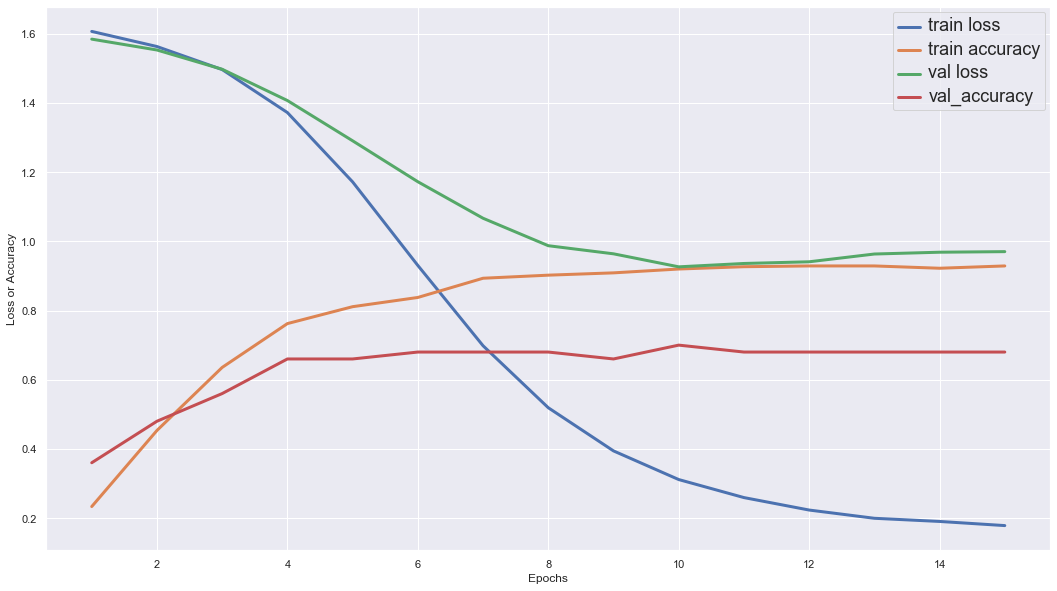

In [56]:
sns.set(font_scale=1)
f, ax = plt.subplots(1, 1, figsize=(18,10))
sns.lineplot(data=plot_df, x='epochs', y='loss', ax=ax, label='train loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='accuracy', ax=ax, label='train accuracy', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_loss', ax=ax, label='val loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_accuracy', ax=ax, label='val_accuracy', linewidth=3)
ax.set_ylabel('Loss or Accuracy')
ax.set_xlabel('Epochs')
plt.setp(ax.get_legend().get_texts(), fontsize='18'); # for legend text

In [57]:
embedding_layer = model.layers[0]
embedding_weights = embedding_layer.get_weights()[0]
print(embedding_weights.shape)

(447, 50)


In [58]:
reverse_word_index = dict([(val, key) for (key, val) in tokenizer.word_index
                       .items()])

In [59]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = embedding_weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()